In [1]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Use pandas and numpy for csv loading and analysis
import pandas as pd
import numpy as np

# Re for matching strings
import string
import re

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt

# NLTK module to do text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to /Users/halcyon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/halcyon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halcyon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/halcyon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/halcyon/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [2]:
# read the inventory csv as dataframe
df = pd.read_csv('/Users/halcyon/Desktop/Data Science for Design/NLS/nls-text-spiritualistNewspaper/spiritualistNewspaper-inventory.csv', header=None, names=['fileid', 'title'])

In [3]:
# expand the collum width to show complete data
pd.set_option('display.max_colwidth', 150)
df['title'] = df['title'].replace('Volume 21. ', '')
df.tail()

,fileid,title
411,136346235.txt,"Spiritualist newspaper - No.412, July 16th 1880 - P.20"
412,136346236.txt,"Spiritualist newspaper - No.413, July 23rd 1880 - P.20"
413,136346237.txt,"Spiritualist newspaper - No.414, July 30th 1880 - P.20"
414,136346239.txt,"Psyche - Volume 21, No.493, March 1882 - K.77.a.7(2)PER"
415,136346240.txt,"Psyche - Volume 21, No.493, May 1882 - K.77.a.7(2)PER"


In [4]:
titles = list(df['title'])
month = []
year = []
for title in titles:
    yr = int((re.search('\d{4}', title))[0]) # Use regular expression to match the format of 4 consecutive digits as year
    year += [yr]
    allMonths = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    title_list = title.split(' ')
    for i in title_list:
        if i in allMonths:  # Use the list of allMonths to match month
            month.append(i)
# print(month[:5])
# print(year[:5])

In [5]:
df['year'] = year
df['month'] = month
df.head()

fileids = list(df['fileid'])
titles = list(df['title'])
inventory = dict(zip(fileids, titles))
# print(inventory)

In [6]:
df[df.fileid.isin(["135908626.txt"])]

,fileid,title,year,month
9,135908626.txt,"Spiritualist - No.10, June 15th 1870 - P.20",1870,June


In [7]:
df.to_csv('data-fileid-year.csv')

Text(0.5, 1.0, 'Yearly Distribution of the Spiritualist Newspaper')

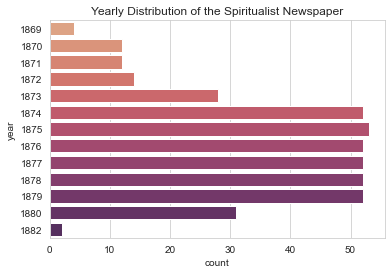

In [8]:
sns.set_style("whitegrid")
yearCount = sns.countplot(y=df.year, palette="flare")
yearCount.set_title("Yearly Distribution of the Spiritualist Newspaper")

# plt.show()

Text(0.5, 1.0, 'Monthly Distribution of the Spiritualist Newspaper')

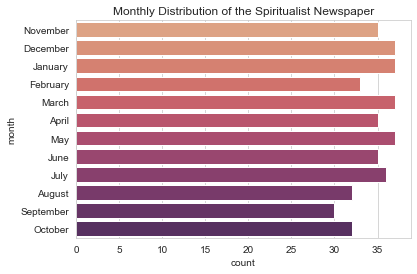

In [9]:
yearCount = sns.countplot(y=df.month, palette="flare")
yearCount.set_title("Monthly Distribution of the Spiritualist Newspaper")

# plt.show()

In [10]:
corpus_folder = '/Users/halcyon/Desktop/Data Science for Design/NLS/nls-text-spiritualistNewspaper'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*')
corpus_tokens = wordlists.words()

In [11]:
def getWordsSents(plaintext_corpus_read_lists):
    all_words = []
    all_words_lower = []
    all_sents = []
    for fileid in fileids:
        # fileids is the sorted list of name in the dataframe
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        all_words += [str(word) for word in file_words if word.isalpha()]
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))
        all_sents += [str(sent) for sent in file_sents]
        # .sents(fileid) returns strings
        # sent_tokenize is also part of the nltk tools
    return all_words, all_words_lower, all_sents

In [12]:
spiritualist_words, spiritualist_words_lower, spiritualist_sents = getWordsSents(wordlists)

In [13]:
isWord = re.compile('[a-zA-z.]+')

In [14]:
def removeNonEnglishWords(list_of_strings):
    english_only = []
    nonenglish = []
    for s in list_of_strings:
        test = isWord.match(s)  # fails if has characters other than letters or a period
        if (test != None):
            passed = test.group()  # get the matching string
            if wordnet.synsets(passed):  # see if WordNet recognizes the matching string
                english_only.append(passed)
            else:
                nonenglish.append(passed)
        else:
            nonenglish.append(passed)
    return english_only, nonenglish

In [15]:
recognised, unrecognised = removeNonEnglishWords(spiritualist_words)

In [16]:
# Filter common english stop words and meaningless words that occur frequently
to_exclude = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + ['also', 'per', '000', 'one', 'many', 'may', 'two', 'see','would','every','could'])

# Short words within the length of 2 are often OCR errors or meaningless words, filter them as well
filtered_lower = [w for w in spiritualist_words_lower if (len(w) > 2 and not w in to_exclude)]

In [17]:
fdist_filtered_lower = FreqDist(filtered_lower) # Calculate words frequent distribution
print("Total words after filtering:", fdist_filtered_lower.N())
print("50 most common words after filtering:", fdist_filtered_lower.most_common(100))

Total words after filtering: 5594170
50 most common words after filtering: [('spirit', 30004), ('spiritualism', 29581), ('mrs', 23471), ('street', 23386), ('london', 19819), ('medium', 18585), ('spiritualist', 18082), ('time', 17633), ('upon', 16414), ('great', 16221), ('life', 16184), ('esq', 16120), ('spiritual', 15904), ('spirits', 15504), ('man', 14220), ('phenomena', 14014), ('spiritualists', 13590), ('said', 13226), ('new', 11974), ('association', 11905), ('well', 11745), ('first', 11580), ('present', 11577), ('given', 11447), ('road', 11257), ('made', 10801), ('world', 10613), ('miss', 10265), ('society', 10164), ('table', 9782), ('place', 9730), ('without', 9702), ('much', 9671), ('work', 9644), ('good', 9528), ('years', 9193), ('book', 9135), ('light', 9086), ('published', 8908), ('manifestations', 8723), ('facts', 8689), ('last', 8677), ('power', 8550), ('like', 8397), ('hand', 8271), ('price', 8191), ('nature', 8178), ('little', 8090), ('room', 8070), ('public', 8054), ('fre

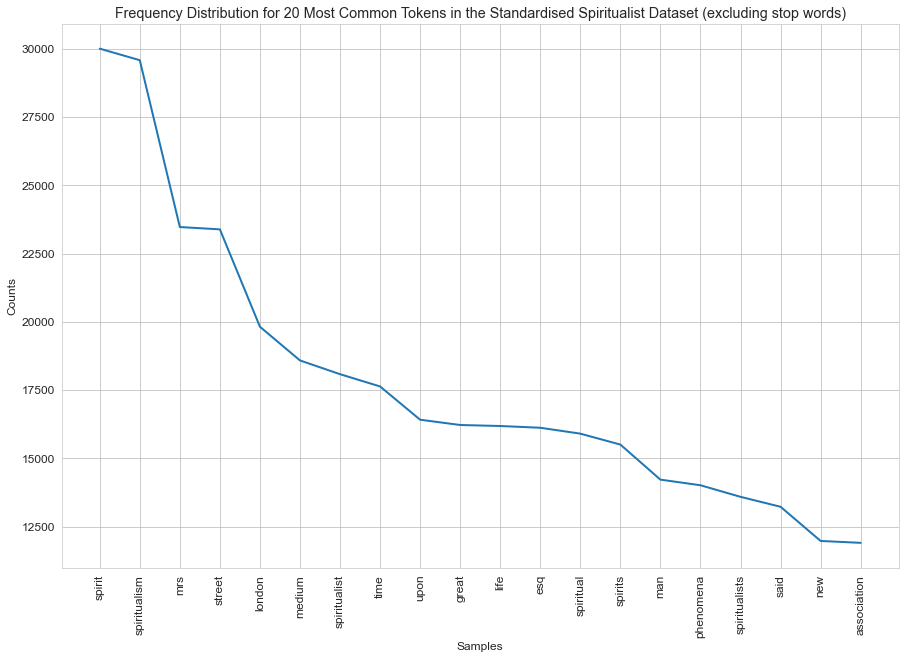

<AxesSubplot:title={'center':'Frequency Distribution for 20 Most Common Tokens in the Standardised Spiritualist Dataset (excluding stop words)'}, xlabel='Samples', ylabel='Counts'>

In [18]:
fdist_filtered_lower = FreqDist(filtered_lower)
plt.figure(figsize = (15, 10))
plt.rc('font', size=12)
number_of_tokens = 20 # indicate number of the most frequently occured words
fdist_filtered_lower.plot(number_of_tokens, title='Frequency Distribution for ' + str(number_of_tokens) + ' Most Common Tokens in the Standardised Spiritualist Dataset (excluding stop words)')

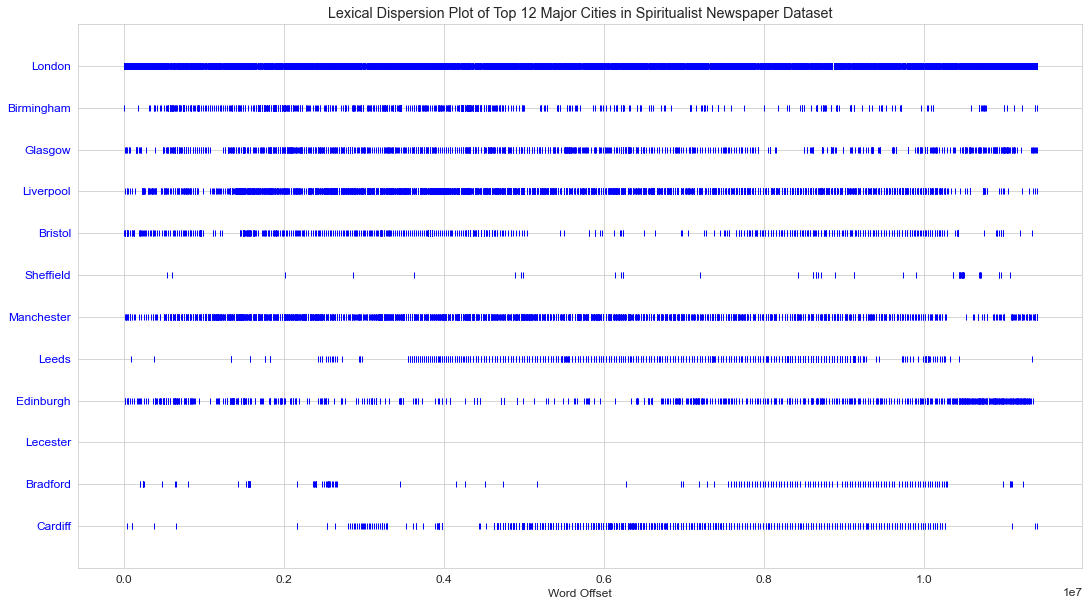

In [19]:
corpus_text = Text(spiritualist_words)
targetCity = ['London', 'Birmingham', 'Glasgow','Liverpool', 'Bristol', 'Sheffield', 'Manchester', 'Leeds','Edinburgh','Lecester','Bradford','Cardiff']
plt.figure(figsize=(18,10))
plt.rc('font', size=12)
displt(corpus_text, targetCity, ignore_case=True, title='Lexical Dispersion Plot of Top 12 Major Cities in Spiritualist Newspaper Dataset')

In [20]:
year_to_fileid = df.groupby('year')['fileid'].apply(list).to_dict()

In [21]:
def getTokens(plaintext_corpus_read_lists, year_files):
    all_words = []
    for fileid in year_files:
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words += [str(word) for word in file_words if word.isalpha()]
    return all_words

In [22]:
year_to_tokens = {}
for ye in year_to_fileid.keys():
    year_to_tokens['list_' + str(ye)] = getTokens(wordlists, year_to_fileid[ye])

In [23]:
print(year_to_tokens["list_1876"][:100])

['llff', 'J', 'l', 'V', 'Ofj', 'd', 'I', 'CIjjj', 'Olb', 'st', 'llttospapr', 'rmT', 'e', 'deb', 'ioit', 'priixmlism', 'xtt', 'eitt', 'xifixht', 'Mintf', 'f', 'No', 'VOL', 'vm', 'No', 'i', 'LQNDQK', 'ERIDAY', 'JANUARY', 'waSSS', 't', 'Published', 'Weekly', 'Price', 'Twopfencaj', 'Contents', 'The', 'Necessity', 'for', 'Mesmeric', 'Experiments', 'in', 'Spiritualism', 'A', 'Haunted', 'House', 'i', 'V', 'kSIsZ', 'u', 'Spirit', 'Teachings', 'No', 'XL', 'v', 'The', 'Prince', 'of', 'Wales', 'among', 'the', 'Ihdiau', 'Jugglers', 'v', 'What', 'is', 'Magic', 'Physical', 'Manifestations', 'among', 'the', 'Greeks', 'and', 'Romans', 'Promised', 'Experiments', 'in', 'Magic', 'Spiritualism', 'in', 'South', 'Africa', 'v', 'c', 'i', 'j', 'Taking', 'Casts', 'of', 'Materialised', 'Spirit', 'Hands', 'The', 'Oracle', 'of', 'the', 'Dead', 'in', 'Thesprotia', 'By']


In [24]:
targets = ['son','daughter','mother','father','cousin']

In [25]:
def wordOccurrenceByYear(word):
    word_occurs = []
    for tokens in year_to_tokens.values(): 
        word_count_capital = tokens.count(word)
        word_lower = word.lower()
        word_count_lower = tokens.count(word_lower)
        total_words = len(tokens)
        occurrence = (word_count_capital + word_count_lower)/total_words
        word_occurs += [occurrence]
    return word_occurs

In [26]:
son = wordOccurrenceByYear('son')
daughter = wordOccurrenceByYear('daughter')
father = wordOccurrenceByYear('father')
mother = wordOccurrenceByYear('mother')

In [27]:
Mon = wordOccurrenceByYear('Monday')
Tue = wordOccurrenceByYear('Tuesday')
Wed = wordOccurrenceByYear('Wednesday')
Thu = wordOccurrenceByYear('Thursday')
Fri = wordOccurrenceByYear('Friday')
Sat = wordOccurrenceByYear('Saturday')
Sun = wordOccurrenceByYear('Sunday')

In [28]:
def wordCountByYear(word):
    word_count = []
    for tokens in year_to_tokens.values():
        word_count_capital = tokens.count(word)
        word_lower = word.lower()
        word_count_lower = tokens.count(word_lower)
        total_count = word_count_capital + word_count_lower
        word_count += [total_count]
    return word_count

In [29]:
murder = wordCountByYear('murder')
suicide = wordCountByYear('suicide')
illness = wordCountByYear('illness')

In [30]:
col_names = ['1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1882']
row_names = ['son','daughter','father','mother','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','murder','suicide','illness']
year_df = pd.DataFrame(data=[son,daughter,father,mother,Mon,Tue,Wed,Thu,Fri,Sat,Sun,murder,suicide, illness], columns=col_names, index=row_names)

In [31]:
year_df = year_df.T
print(year_df.head())
year_df.to_csv('data-family-weekday-death.csv')

           son  daughter    father    mother    Monday   Tuesday  Wednesday  \
1869  0.000384  0.000192  0.000664  0.000804  0.000017  0.000122   0.000061   
1870  0.000311  0.000113  0.000436  0.000382  0.000090  0.000057   0.000075   
1871  0.000188  0.000206  0.000418  0.000418  0.000088  0.000051   0.000085   
1872  0.000312  0.000215  0.000339  0.000485  0.000065  0.000081   0.000046   
1873  0.000210  0.000161  0.000275  0.000368  0.000125  0.000090   0.000142   

      Thursday    Friday  Saturday    Sunday  murder  suicide  illness  
1869  0.000079  0.000166  0.000070  0.000157    14.0      2.0      2.0  
1870  0.000108  0.000134  0.000116  0.000302    14.0      4.0     24.0  
1871  0.000103  0.000094  0.000079  0.000188     2.0      6.0     18.0  
1872  0.000129  0.000092  0.000124  0.000124    26.0     20.0     16.0  
1873  0.000253  0.000097  0.000091  0.000290    14.0      8.0     32.0  
